In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack

import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
import seaborn as sns

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [5]:

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(2))
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))


In [6]:
from keras.optimizers import Adam


model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [7]:
#fitting the model and predicting 

# fit network
model_history=model.fit(x=trainX, y=trainy, epochs=10, batch_size=16,validation_data= (testX,testy))
predy = model.predict(testX)

testy_class = np.argmax(testy,axis=1)
predy_class = np.argmax(predy,axis=1)

Epoch 1/10
460/460 [==============================] - 9s 16ms/step - loss: 0.8309 - accuracy: 0.6353 - val_loss: 0.6303 - val_accuracy: 0.7672
Epoch 2/10
460/460 [==============================] - 7s 15ms/step - loss: 0.5784 - accuracy: 0.7518 - val_loss: 0.5555 - val_accuracy: 0.8107
Epoch 3/10
460/460 [==============================] - 7s 14ms/step - loss: 0.4670 - accuracy: 0.8082 - val_loss: 0.4770 - val_accuracy: 0.8480
Epoch 4/10
460/460 [==============================] - 6s 14ms/step - loss: 0.3895 - accuracy: 0.8411 - val_loss: 0.5007 - val_accuracy: 0.8653
Epoch 5/10
460/460 [==============================] - 5s 10ms/step - loss: 0.3424 - accuracy: 0.8532 - val_loss: 0.4786 - val_accuracy: 0.8663
Epoch 6/10
460/460 [==============================] - 4s 8ms/step - loss: 0.3145 - accuracy: 0.8730 - val_loss: 0.4511 - val_accuracy: 0.8663
Epoch 7/10
460/460 [==============================] - 3s 7ms/step - loss: 0.2971 - accuracy: 0.8810 - val_loss: 0.4402 - val_accuracy: 0.8778
E

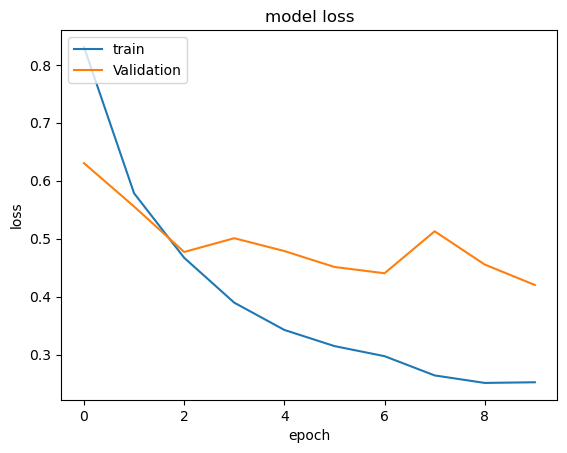

In [9]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [11]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(testy_class,predy_class))
print(confusion_matrix(testy_class,predy_class))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89       496
           1       0.91      0.91      0.91       471
           2       0.78      1.00      0.87       420
           3       0.82      0.76      0.79       491
           4       0.83      0.84      0.83       532
           5       1.00      0.99      0.99       537

    accuracy                           0.88      2947
   macro avg       0.89      0.89      0.88      2947
weighted avg       0.89      0.88      0.88      2947

[[404   9  83   0   0   0]
 [  5 430  36   0   0   0]
 [  2   0 418   0   0   0]
 [  0  24   0 372  95   0]
 [  1   3   0  79 449   0]
 [  0   7   0   0   0 530]]
